It could be that the coordinate system we get everything in, is actually the one from the Top View. 

In [1]:
from utils import (
    load_dataset,
    get_images,
    transform_points,
    predict,
    SCALING_FACTOR
)
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
filename = 'mini3.json'

with open(filename, 'r') as file:
    data = json.load(file)
K = data['mtx']
dist = data['dist']
K = np.array(K)
dist = np.array(dist)

In [12]:
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset('DJI_0017', 'DJI_0017')
img_pv, img_tv = get_images('DJI_0017', 'DJI_0017')
reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

h, _ = cv2.findHomography(
    reference_pts_pv_arr,
    reference_pts_tv_arr,
    # method = cv2.RANSAC,
    method = 0,
)
h_inv = np.linalg.inv(h)

In [13]:
H = h_inv.T
h1 = H[0]
h2 = H[1]
h3 = H[2]
K_inv = np.linalg.inv(K)
L = 1 / np.linalg.norm(np.dot(K_inv, h1))
r1 = L * np.dot(K_inv, h1)
r2 = L * np.dot(K_inv, h2)
r3 = np.cross(r1, r2)
T = L * (K_inv @ h3.reshape(3, 1))
R = np.array([[r1], [r2], [r3]])
R = np.reshape(R, (3, 3))

In [35]:
T0 = -T

[[-3.06206246e-01 -6.22683123e-01  7.20071846e-01]
 [ 9.77037783e-01 -1.99003092e-01  2.29077470e-01]
 [ 6.53849662e-04  7.73682351e-01  6.69320928e-01]]


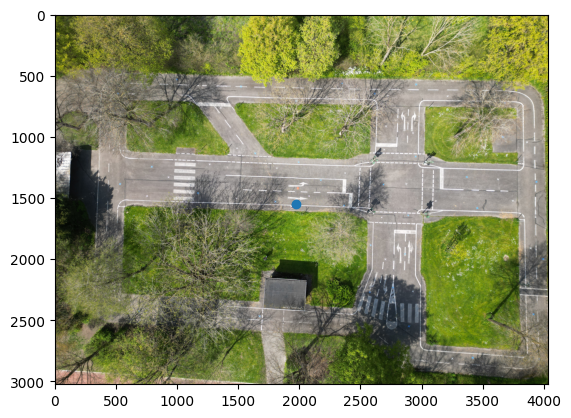

In [21]:
plt.imshow(img_tv)
plt.scatter(T0[0], T0[1])

Now if I calculate some position it is in RELATION to this T!

In [91]:
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset('DJI_0026', 'DJI_0017')

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

h, _ = cv2.findHomography(
    reference_pts_pv_arr,
    reference_pts_tv_arr,
    # method = cv2.RANSAC,
    method = 0,
)
h_inv = np.linalg.inv(h)

In [85]:
H = h_inv.T
h1 = H[0]
h2 = H[1]
h3 = H[2]
K_inv = np.linalg.inv(K)
L = 1 / np.linalg.norm(np.dot(K_inv, h1))
r1 = L * np.dot(K_inv, h1)
r2 = L * np.dot(K_inv, h2)
r3 = np.cross(r1, r2)
T = L * (K_inv @ h3.reshape(3, 1))
R = np.array([[r1], [r2], [r3]])
R = np.reshape(R, (3, 3))
T = -R@T
print(T)

[[2709.2125776 ]
 [1570.45657785]
 [-544.62256893]]


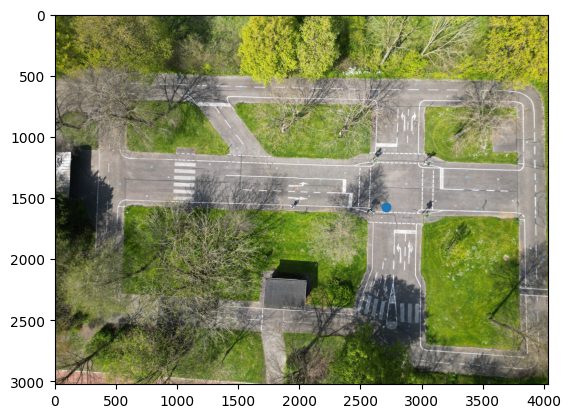

In [86]:
plt.imshow(img_tv)
plt.scatter(T[0], T[1])

In [90]:
from scipy.spatial.transform import Rotation as SpicyR
rotation = SpicyR.from_matrix(R)
euler_angles = rotation.as_euler('xyz', degrees=True)
roll, pitch, yaw = euler_angles
print(roll-90, pitch, yaw)

-40.45333045952798 0.1726801543315064 33.230091625094296


In [109]:
def get_pose(pv_img):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, 'DJI_0017')
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    H = h_inv.T
    h1 = H[0]
    h2 = H[1]
    h3 = H[2]
    K_inv = np.linalg.inv(K)
    L = 1 / np.linalg.norm(np.dot(K_inv, h1))
    r1 = L * np.dot(K_inv, h1)
    r2 = L * np.dot(K_inv, h2)
    r3 = np.cross(r1, r2)
    T = L * (K_inv @ h3.reshape(3, 1))
    R = np.array([[r1], [r2], [r3]])
    R = np.reshape(R, (3, 3))
    T = -R@T
    rotation = SpicyR.from_matrix(R)
    euler_angles = rotation.as_euler('xyz', degrees=True)
    roll, pitch, yaw = euler_angles
    return roll-92, T
pitch, position = get_pose('DJI_0026')
print(pitch)

-42.45333045952798


In [110]:
gt_pitches = [-43.0,
-43.0 ,
-43.0 ,
-43.0 ,
-38.1 ,
-27.8 ,
-38.5 ,
-32.1 ,
-43.5 ,
-38.7 ,
-47.3 ,
-36.8]

In [111]:
for fname, gt in zip(['DJI_0026', 'DJI_0029', 'DJI_0032', 'DJI_0035', 'DJI_0038', 'DJI_0045', 'DJI_0049', 'DJI_0053', 'DJI_0061', 'DJI_0066', 'DJI_0067', 'DJI_0078'],
                 gt_pitches):
    pitch, position = get_pose(fname)
    print(pitch, gt)

-42.45333045952798 -43.0
-42.839033004187904 -43.0
-43.716624611522896 -43.0
-43.26844805039871 -43.0
-38.311466333351724 -38.1
-26.28759405024944 -27.8
-36.872090606215146 -38.5
-31.350078871477336 -32.1
-42.63861825636793 -43.5
-37.15194001690583 -38.7
-46.055966428108384 -47.3
-36.65066019469157 -36.8
